# Decision Analysis Project 1

## Installs and Imports

In [155]:
#Installs go here

In [156]:
#Imports go here
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## Utilities

In [157]:
def calculate_value(value, q, p):
    if value > p:
        return 1.0
    elif value<=q:
        return 0
    return (value-q)/(p-q)

class Criteria:
    '''
    Criteria class for PROMETHEE and ELECTRE implementations.
    '''
    def __init__(self, name: str, criteria_type: str, w: float, q: float, p:float, v:float = float("inf")):
        '''
        Initialize instance of Criteria.
        Parameters:
            - name (str): Criteria name, e.g. (cost, completion time, rating, etc.)
            - criteria_type (str): Criteria type - 'gain' (higher values preffered) or 'cost' (lower values preffered)
            - w (float): Criteria weight
            - q (float): Indifference threshold
            - p (float): Perference threshold
            - v (float, optional): Veto threshold, default infinite -> used only for ELECTRE
        '''
        self.name = name
        assert criteria_type.lower() == "gain" or criteria_type.lower() == "cost", "Invalid criteria type"
        assert q<=p and p<=v and p>=0 and q>=0 and w>=0, "Invalid values, expected: q<p<v and q,p,w >=0"
        assert not np.isposinf(w) and not np.isneginf(w), "Invalid value, weight cannot be infinite"
        self.criteria_type = criteria_type.lower()
        self.w = w
        self.q = q
        self.p = p
        self.v = v

    def __str__(self):
        '''
        Print information about Criteria.
        '''
        return f"Criteria: {self.name} \n type: {self.criteria_type} \n w: {self.w} \n q: {self.q} \n p: {self.p} \n v: {self.v} \n"

## PROMETHEE

In [158]:
class PROMETHEE:
    def __init__(self, name: str = "MCDA Problem", criteria: list = [], alternatives = None, initialize_from_input: bool = False, initialize_from_file: bool = False, criteria_path = "", alternatives_path = "", version: int = 1):
        if alternatives is not None and not isinstance(alternatives, pd.DataFrame):
            raise TypeError("Alternatives must be a pandas DataFrame.")

        if not initialize_from_input and not initialize_from_file and len(criteria) == 0:
            warnings.warn("Criteria empty but idata from file or input is not read >:(", UserWarning)

        self.name = name
        if version != 1 and version != 2:
            raise ValueError("Only supported versions are 1 and 2")
        self.version = version

        if initialize_from_file:
            self.initalize_data_from_file(criteria_path, alternatives_path, criteria)

        elif initialize_from_input:
            self.initalize_data_from_input()

        else:
            self.criteria = criteria
            self.alternatives = alternatives

    def initalize_data_from_input(self):
        print("\n-----------------Initalize Criteria----------------\n")
        num_criteria = int(input("Num criteria = "))
        criterias = []
        for i in range(num_criteria):
            name = str(input("Name: "))
            cr_type = str(input("Type: "))
            w = int(input("Weight: "))
            q = int(input("Indifference Threshold: "))
            p = int(input("Preference Threshold: "))
            criterias.append(Criteria(name, cr_type, w, q, p))
        self.criteria = criterias

        print("\n------------------Initalize Alternatives--------------\n")
        num_alternatives = int(input("Num alternatives = "))
        alternatives = {criterias[i].name: [] for i in range(len(criterias))}
        alternatives["name"] = []
        for i in range(num_alternatives):
            name = str(input("ALternative Name: "))
            alternatives["name"].append(name)
            for ii in range(num_criteria):
                value = float(input(f"{criterias[ii].name} value: "))
                alternatives[criterias[ii].name].append(value)
        alternatives = pd.DataFrame.from_dict(alternatives)
        self.alternatives = alternatives

    def initalize_data_from_file(self, criteria_path, alternatives_path, criteria):
        if criteria_path == "":
            self.criteria = criteria
        else:
            self.criteria = pd.read_csv(criteria_path)
        self.alternatives = pd.read_csv(alternatives_path)

    def __str__(self):
        promethee_text = f"PROMETHEE {self.name}, version: {self.version}"
        for criterion in self.criteria:
            cr_printed = criterion.__str__()
            promethee_text += cr_printed
        promethee_text += "\n-----------------------Alternatives-----------------------\n"
        promethee_text += self.alternatives.__str__()
        return promethee_text

    def display(self):
        promethee_text = f"PROMETHEE {self.name}, version: {self.version}"
        for criterion in self.criteria:
            cr_printed = criterion.__str__()
            promethee_text += cr_printed
        promethee_text += "\n-----------------------Alternatives-----------------------\n"
        print(promethee_text)
        return self.alternatives.head(len(self.alternatives))

    def get_marginal_preference_index(self):
        marginal_index = {name: None for name in self.alternatives["name"]}
        copied_alts = self.alternatives.drop(columns=["name"])
        for i, row in copied_alts.iterrows():
            diff = copied_alts.sub(row)
            for crt in self.criteria:
                if crt.criteria_type == "gain":
                    diff[crt.name] *= -1
                diff[crt.name] = diff[crt.name].apply(calculate_value, args=(crt.q, crt.p))
            diff["name"] = self.alternatives["name"]
            marginal_index[self.alternatives["name"][i]]=diff
        return marginal_index

    def get_comprehensive_preference_index(self, marginal_index):
        comprehensive_preference_index = {name:[] for name in self.alternatives["name"]}
        weights = np.array([crit.w for crit in self.criteria])
        for alt_name in self.alternatives["name"]:
            temp_marginal_index = marginal_index[alt_name].drop(columns=["name"])
            temp_marginal_index = temp_marginal_index.values
            weighted_index = temp_marginal_index * weights
            result_sum = np.sum(weighted_index, axis=1)
            weight_sum = np.sum(weights)
            comprehensive_index_row = result_sum/weight_sum
            for i, val in enumerate(comprehensive_index_row):
                comprehensive_preference_index[self.alternatives["name"][i]].append(val)
        comprehensive_preference_index = pd.DataFrame.from_dict(comprehensive_preference_index)
        comprehensive_preference_index["name"] = self.alternatives["name"]
        return comprehensive_preference_index

    def get_positive_flow(self, comprehensive_preference_index):
        positive_flow = pd.DataFrame(comprehensive_preference_index.drop(columns=["name"]).sum(axis=1), columns = ["Positive Flow"])
        positive_flow["name"] = comprehensive_preference_index["name"]
        return positive_flow

    def get_negative_flow(self, comprehensive_preference_index):
        negative_flow = pd.DataFrame(comprehensive_preference_index.sum(axis=0), columns = ["Negative Flow"])
        negative_flow.reset_index(inplace=True)
        negative_flow.rename(columns={'index': 'name'}, inplace=True)
        negative_flow = negative_flow[negative_flow['name'] != 'name']
        return negative_flow

    def get_complete_flow(self, positive_flow, negative_flow):
        names = positive_flow["name"]
        complete_flow = positive_flow.drop(columns=["name"]).values - negative_flow.drop(columns=["name"]).values
        return pd.DataFrame({'name': names, 'Complete Flow': complete_flow.flatten()})

    def get_complete_names_ranking(self, complete_flow, epsilon = 1e-5):
        prev_flow = float("inf")
        new_flow = []
        for i, row in complete_flow.iterrows():
            if row["Complete Flow"]<prev_flow+epsilon and row["Complete Flow"]>prev_flow-epsilon:
                new_flow[-1].append(row["name"])
            else:
                new_flow.append([row["name"]])
            prev_flow = row["Complete Flow"]
        return new_flow

    def create_complete_ranking_graph(self, ordered_names):
        G = nx.DiGraph()
        new_names = []
        for name_list in ordered_names:
            if len(name_list)>1:
                new_name = ""
                for name in name_list:
                    new_name += "\"" + name + "\" "
                new_names.append(new_name)
            else:
                new_names.append(name_list[0])
        for name in new_names:
            G.add_node(name)
        for i in range(len(new_names)-1):
            G.add_edge(new_names[i], new_names[i+1])
        return G

    def get_partial_ranking(self, positive_flow, negative_flow):
        positive_flow = positive_flow.sort_values(by="Positive Flow", ascending = False)
        negative_flow = negative_flow.sort_values(by="Negative Flow", ascending = True)
        ordered_names = []
        added_names = []
        same_flows = []
        for i, row1 in positive_flow.iterrows():
            if row1["name"] not in added_names:
                added_names.append(row1["name"])
                ordered_names.append([row1["name"]])
            else:
                continue
            for ii, row2 in negative_flow.iterrows():
                if row1["name"] == row2["name"]:
                    break
                if row2["name"] not in added_names:
                    added_names.append(row2["name"])
                    ordered_names[-1].append(row2["name"])
        same_positive = {name: [] for name in positive_flow["name"]}
        same_negative = {name: [] for name in positive_flow["name"]}

        for i, row1 in positive_flow.iterrows():
            for ii, row2 in positive_flow.iterrows():
                if row1["Positive Flow"] == row2["Positive Flow"]:
                    same_positive[row1["name"]].append(row2["name"])

        for i, row1 in negative_flow.iterrows():
            for ii, row2 in negative_flow.iterrows():
                if row1["Negative Flow"] == row2["Negative Flow"]:
                    same_negative[row1["name"]].append(row2["name"])

        added_names = []
        for name in positive_flow["name"]:
            for pos_val in same_positive[name]:
                same_flows.append([])
                for neg_val in same_negative[name]:
                    if pos_val == neg_val and pos_val != name and pos_val not in added_names and neg_val not in added_names:
                        added_names.append(pos_val)
                        added_names.append(neg_val)
                        same_flows[-1].append(neg_val)
                        if name not in same_flows[-1]:
                            same_flows.append(name)

        new_ordered_names = ordered_names
        for i in range(len(ordered_names)):
            for flow_list in same_flows:
                complete_name = ""
                change = False
                for name in flow_list:
                    if name in ordered_names[i]:
                        change = True
                        complete_name += name + " "
                        new_ordered_names[i].remove(name)
                if change:
                    new_ordered_names[i].append(complete_name)
        return new_ordered_names

    def get_partial_ranking_graph(self, ordered_names):
        G = nx.DiGraph()
        for name_list in ordered_names:
            for name in name_list:
                G.add_node(name)
        for i in range(len(ordered_names)-1):
            curr_nodes = ordered_names[i]
            next_nodes = ordered_names[i+1]
            for name in curr_nodes:
                for next_name in next_nodes:
                    G.add_edge(name, next_name)
        return G

    def solve(self):
        marginal_preference_index = self.get_marginal_preference_index()
        comprehensive_preference_index = self.get_comprehensive_preference_index(marginal_preference_index)
        positive_flow = self.get_positive_flow(comprehensive_preference_index)
        negative_flow = self.get_negative_flow(comprehensive_preference_index)
        if self.version == 1:
            ordered_names = self.get_partial_ranking(positive_flow, negative_flow)
            partial_ranking_graph = self.get_partial_ranking_graph(ordered_names)
            return ordered_names, partial_ranking_graph
        else:
            complete_flow = self.get_complete_flow(positive_flow, negative_flow)
            complete_flow = complete_flow.sort_values(by='Complete Flow', ascending=False)
            ordered_names = self.get_complete_names_ranking(complete_flow)
            complete_ranking_graph = self.create_complete_ranking_graph(ordered_names)
        return ordered_names, complete_ranking_graph

In [159]:
criteria = [
    Criteria(name = "price", criteria_type = "cost", w = 2.0, q = 3.0, p=9.0),
    Criteria(name = "critic_score", criteria_type = "gain", w = 1.0, q = 0.0, p=1.0),
    Criteria(name = "user_score", criteria_type = "gain", w = 5.0, q = 1.0, p=2.0),
    Criteria(name = "length", criteria_type = "gain", w = 6.0, q = 5.0, p=20.0),
    Criteria(name = "genres", criteria_type = "gain", w = 2.5, q = 9.0, p=15.0),
    Criteria(name = "num_of_achievements", criteria_type = "gain", w = 8.0, q = 3.3, p=92.0),
]

In [160]:
promete = PROMETHEE(initialize_from_file=True, criteria = criteria, alternatives_path = "/content/data.csv")

In [161]:
print(promete)

PROMETHEE MCDA Problem, version: 1Criteria: price 
 type: cost 
 w: 2.0 
 q: 3.0 
 p: 9.0 
 v: inf 
Criteria: critic_score 
 type: gain 
 w: 1.0 
 q: 0.0 
 p: 1.0 
 v: inf 
Criteria: user_score 
 type: gain 
 w: 5.0 
 q: 1.0 
 p: 2.0 
 v: inf 
Criteria: length 
 type: gain 
 w: 6.0 
 q: 5.0 
 p: 20.0 
 v: inf 
Criteria: genres 
 type: gain 
 w: 2.5 
 q: 9.0 
 p: 15.0 
 v: inf 
Criteria: num_of_achievements 
 type: gain 
 w: 8.0 
 q: 3.3 
 p: 92.0 
 v: inf 

-----------------------Alternatives-----------------------
                             name  price  critic_score  user_score  length  \
0          Dark Souls: Remastered    150            84          83      44   
1                  Dark Souls III    200            89          90      49   
2                        Terraria     46            81          81     102   
3                 Baldur's Gate 3    250            96          89     107   
4                  Dave the Diver     92            90          83      32   
5          

In [162]:
promete.display()

PROMETHEE MCDA Problem, version: 1Criteria: price 
 type: cost 
 w: 2.0 
 q: 3.0 
 p: 9.0 
 v: inf 
Criteria: critic_score 
 type: gain 
 w: 1.0 
 q: 0.0 
 p: 1.0 
 v: inf 
Criteria: user_score 
 type: gain 
 w: 5.0 
 q: 1.0 
 p: 2.0 
 v: inf 
Criteria: length 
 type: gain 
 w: 6.0 
 q: 5.0 
 p: 20.0 
 v: inf 
Criteria: genres 
 type: gain 
 w: 2.5 
 q: 9.0 
 p: 15.0 
 v: inf 
Criteria: num_of_achievements 
 type: gain 
 w: 8.0 
 q: 3.3 
 p: 92.0 
 v: inf 

-----------------------Alternatives-----------------------



,name,price,critic_score,user_score,length,genres,num_of_achievements
0,Dark Souls: Remastered,150,84,83,44,11,41
1,Dark Souls III,200,89,90,49,11,43
2,Terraria,46,81,81,102,9,115
3,Baldur's Gate 3,250,96,89,107,8,54
4,Dave the Diver,92,90,83,32,7,43
5,Rust,153,69,65,37,10,92
6,Hollow Knight,68,90,91,42,10,63
7,Portal 2,46,95,89,14,7,51
8,Vampire Survivors,20,86,83,25,9,204
9,Hades,115,93,88,49,9,49


In [163]:
result, graph = promete.solve()

In [164]:
result

[['Terraria', 'Hollow Knight', 'Skyrim', "Baldur's Gate 3"],
 ['Vampire Survivors', 'Hades', 'Dark Souls III'],
 ['The Sims 3', 'Portal 2'],
 ['Enter the Gungeon'],
 ['Dishonored'],
 ['Subnautica',
  'Dave the Diver',
  'Dying Light',
  'Dark Souls: Remastered',
  'Ori and the Will of the Wisps'],
 ['Rust', 'The Forest'],
 ['Inside', "Assassin's Creed Unity", 'Trials Fusion', 'Teardown'],
 ['Titan Souls'],
 ['Kao the Kangaroo'],
 ['Payday 3']]

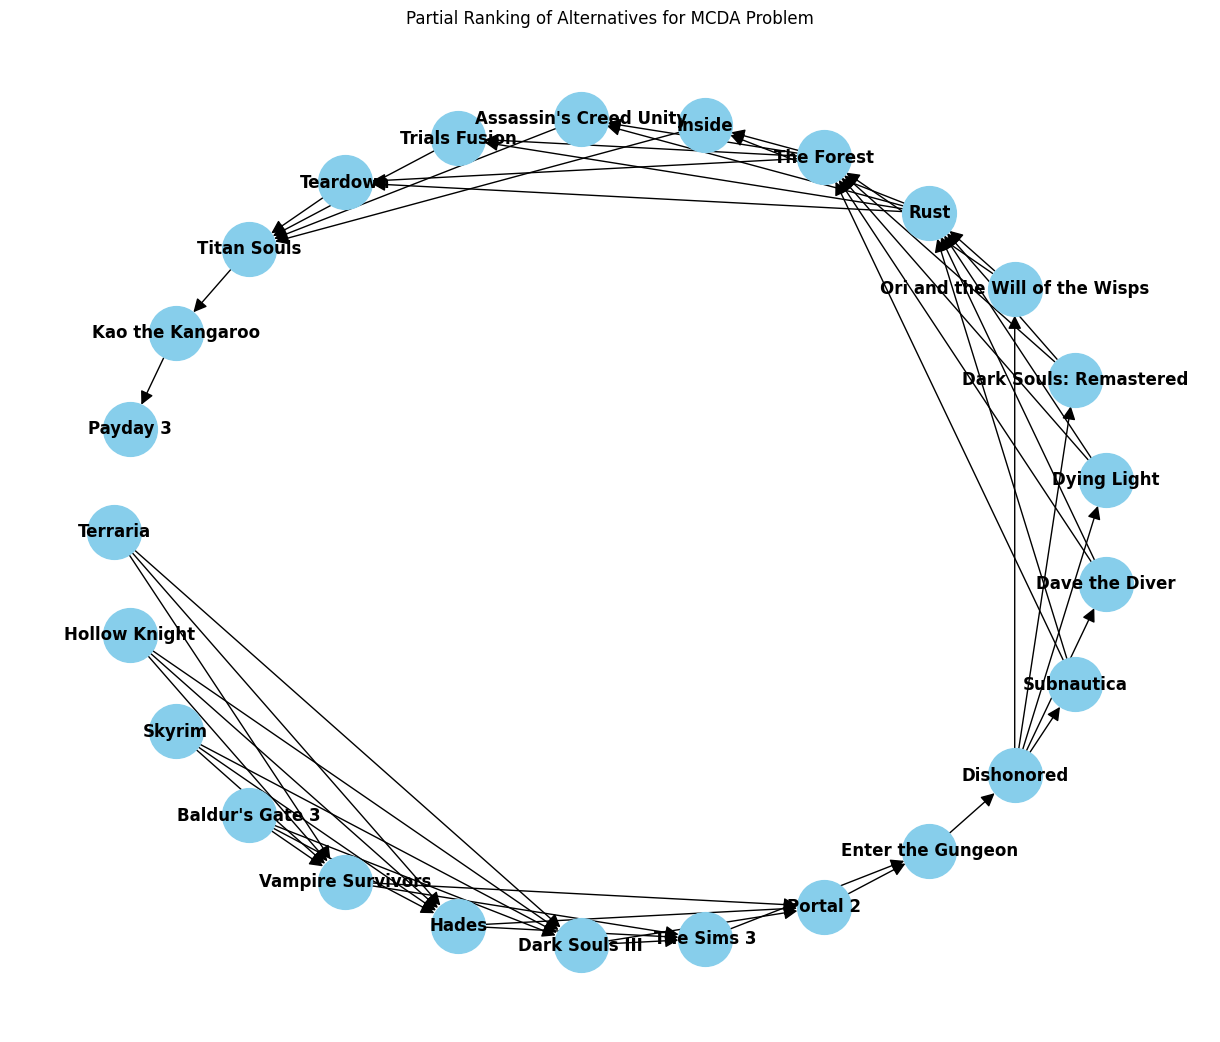

In [165]:
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title(f'Partial Ranking of Alternatives for {promete.name}')
plt.show()

In [166]:
#plt.figure(figsize=(12, 10))
#pos = nx.shell_layout(graph)
#nx.draw(graph, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
#plt.title(f'Complete Ranking of Alternatives for {promete.name}')
#plt.show()

## SRF

## ELECTRE

## Use